In [1]:
import os

import datetime
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.fft import fft
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.lines as mlines
import seaborn as sns
import skill_metrics as sm
from sklearn.metrics import r2_score

import matplotlib.patches as mpatches

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors  # For RGBA to hex conversion

from src.plots import *
from src.utilities import cal_metrics, mielke_lambda, percentile_mean, fluctuation_frequency

In [2]:
# Set inputs
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission
fp_resub = 'resubmissions/{}' # File path for resubmission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_targ_short = 'shorelines_hidden_short.csv' # File name for target shoreline (short-term)
fn_targ_medium = 'shorelines_hidden_medium.csv' # File name for target shoreline (medium-term)
fn_pred_short = 'shorelines_prediction_short.csv' # File name for predicted shoreline (short-term)
fn_pred_medium = 'shorelines_prediction_medium.csv' # File name for predicted shoreline (medium-term)
fn_pred_RCP45 = 'shorelines_prediction_long_RCP45.csv' # File name for predicted shoreline (short-term)
fn_pred_RCP85 = 'shorelines_prediction_long_RCP85.csv' # File name for predicted shoreline (medium-term)

In [3]:
# Read model metadata
df_meta = pd.read_excel('model_summary.xlsx', header=[1])
df_meta = df_meta[~df_meta['Model Name'].str.contains('corrected_JAAA')]
df_meta = df_meta[df_meta['Submission Type']=='Submission']


df_meta['Process'] = 'CS_LS'
df_meta.loc[(df_meta['Cross-Shore'].isna())&(~df_meta['Long-Shore'].isna()), 'Process']='LS_Only'
df_meta.loc[(~df_meta['Cross-Shore'].isna())&(df_meta['Long-Shore'].isna()), 'Process']='CS_Only'
df_meta = df_meta[(~df_meta['Long'].isna())&(~df_meta['Sea level'].isna())]

In [9]:
# Read model calibrations
dfs_pred_RCP45 = {}
for model in df_meta['Model Name']:
    if os.path.exists(os.path.join(fp_sub.format(model), fn_pred_RCP45)):
        if df_meta.loc[df_meta['Model Name']==model, 'Submission Type'].values[0] == 'Submission':
            fp = fp_sub
        else:
            fp = fp_resub
        try:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_RCP45), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred_RCP45), index_col='datetime')
            df_pred.index.name = 'Datetime'
        if df_pred.iloc[0].mean()<100: # Some COCOONED model provides relative shoreline position
            df_pred_short = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_short), index_col='Datetime')
            df_pred = df_pred + df_pred_short.iloc[0] - df_pred.iloc[0]
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred_RCP45[model] = df_pred.resample('1MS').mean()
    else:
        print(model)

In [10]:
dfs_pred_RCP85 = {}
for model in df_meta['Model Name']:
    if os.path.exists(os.path.join(fp_sub.format(model), fn_pred_RCP85)):
        try:
            df_pred = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_RCP85), index_col='Datetime')
        except:
            df_pred = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_RCP85), index_col='datetime')
            df_pred.index.name = 'Datetime'
        if df_pred.iloc[0].mean()<100: # Some COCOONED model provides relative shoreline position
            df_pred_short = pd.read_csv(os.path.join(fp_sub.format(model), fn_pred_short), index_col='Datetime')
            df_pred = df_pred + df_pred_short.iloc[0]  - df_pred.iloc[0]
        
        df_pred.index = pd.to_datetime(df_pred.index)
        df_pred.sort_index(inplace=True)
        dfs_pred_RCP85[model] = df_pred.resample('1MS').mean()

In [11]:
# Calculate position of dune
gdf_tran = gpd.read_file('datasets/transect_coords.geojson').set_index('name')
gdf_dune = gpd.read_file('datasets/hidden/dune.geojson')
gdf_intersect = gdf_tran.intersection(gdf_dune.loc[0, 'geometry'])
gdf_tran['Dune dist'] = gdf_tran.geometry.interpolate(0).distance(gdf_intersect)

C:\Users\z3541792\AppData\Local\anaconda3\envs\GEE\lib\site-packages\geopandas\array.py:640: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vectorized.interpolate(self.data, distance, normalized=normalized),


In [12]:
def fall_velocity_calc(D,Tw=15):


    """
    Calculates dimensionless fall velocity assuming T = 15 deg C
    Args:
        D: d50 in [m]
        g: Acceleration due to gravity
    Returns:
        dimensionless fall velocity in m/s
    """
    D=D*100
    ROWs=2.75 #Density of sand 
    g=981     #Gravity n cm**2/s

    T=np.array([5 ,10, 15, 20, 25])
    v   =np.array([0.0157, 0.0135, 0.0119, 0.0105, 0.0095])
    ROW =np.array([1.028, 1.027, 1.026, 1.025, 1.024])

    vw=np.interp(Tw,T,v)
    ROWw=np.interp(Tw,T,ROW)    

    A=((ROWs-ROWw)*g*(D**3))/(ROWw*(vw**2))

    if  A < 39 :
        w = ((ROWs-ROWw)*g*(D**2))/(18*ROWw*vw)

    elif (A < 10**4) & (A > 39):
        w = ((((ROWs-ROWw)*g/ROWw)**0.7)*(D**1.1))/(6*(vw**0.4))   
    else:
        w = np.sqrt(((ROWs-ROWw)*g*D)/(0.91*ROWw))
    w=w/100 #convert to SI (m/s)

    return w

C:\Users\z3541792\AppData\Local\anaconda3\envs\GEE\lib\site-packages\pandas\core\tools\timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)
C:\Users\z3541792\AppData\Local\anaconda3\envs\GEE\lib\site-packages\pandas\core\tools\timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)
C:\Users\z3541792\AppData\Local\anaconda3\envs\GEE\lib\site-packages\pandas\core\tools\timedeltas.py:142: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)
C:\Users\z3541792\AppData\Local\anaconda3\envs\GEE\lib\site-packages\pandas\core\tools\time

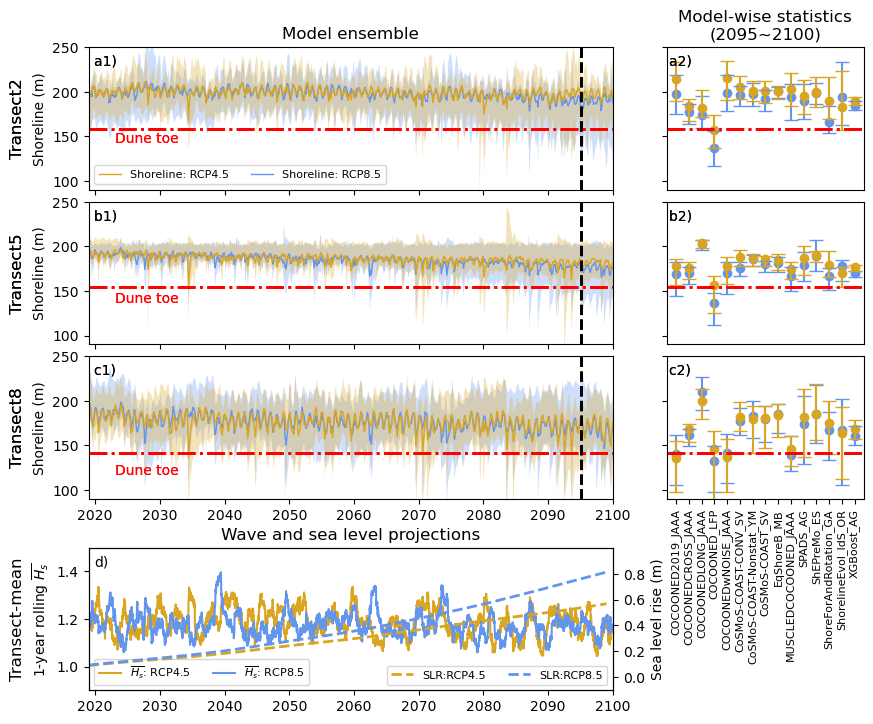

In [13]:
df_SLR = pd.read_csv('datasets/sealevel/sealevel_proj.csv', parse_dates=['Year']).set_index('Year')
ens_colors = {'RCP4.5':'goldenrod', 'RCP8.5':'cornflowerblue'}
dfs_sce = {'RCP4.5':dfs_pred_RCP45, 'RCP8.5':dfs_pred_RCP85}
fig, axes = plt.subplots(5, 2, figsize=(10, 2*len(TRANSECTS)+0.35+2), gridspec_kw={'width_ratios': [8, 3], 
                                                                              'height_ratios':[2, 2, 2, 0.35, 2]}) 
letters = string.ascii_lowercase # Letters used to label subplots
index = pd.date_range(start='2019-01-01', end='2100-01-01', freq='MS')

for sce in ['RCP8.5', 'RCP4.5']:
    dfs_pred = dfs_sce[sce]
    ensemble_values = []
    for key, df_pred in dfs_pred.items():
        ensemble_values.append(df_pred[TRANSECTS].reindex(index).interpolate().values)  
    ensemble_values = np.stack(ensemble_values)
    #ensemble_mean = np.mean(ensemble_values, axis=0)
    ensemble_mean = percentile_mean(ensemble_values, 10, 90, axis=0)
    ensemble_median = np.median(ensemble_values, axis=0)
    ensemble_max = np.max(ensemble_values, axis=0)
    ensemble_min = np.min(ensemble_values, axis=0)
    ensemble_std = np.std(ensemble_values, axis=0)
    
    
    
    for i, tran_id in enumerate(TRANSECTS):
        ax = axes[i, 0]
        ax.fill_between(index, ensemble_min[:, i], ensemble_max[:, i], color=ens_colors[sce], edgecolor='none', alpha=0.3)
#         ax.fill_between(index, ensemble_mean[:, i]+ensemble_std[:, i], 
#                         ensemble_mean[:, i]-ensemble_std[:, i], color=ens_colors[sce], edgecolor='none', alpha=0.4)
        ax.plot(index, ensemble_mean[:, i], color=ens_colors[sce], label='Shoreline: '+sce, linewidth=1)
        ax.axhline(gdf_tran.loc[tran_id, 'Dune dist'], color='r', linewidth=2, linestyle='-.')
        ax.axvline(datetime.datetime(year=2095, month=1, day=1), color='k', linewidth=2, linestyle='--')
        ax.text(0.05, (gdf_tran.loc[tran_id, 'Dune dist']-125)/100, 'Dune toe', color='r', transform=ax.transAxes)
        
#         ax2 = ax.twinx()
#         ax2.plot(df_SLR.index, df_SLR['RCP85'], color='royalblue', linewidth=1, linestyle='--', label='SLR:RCP8.5')
#         ax2.plot(df_SLR.index, df_SLR['RCP45'], color='darkgoldenrod', linewidth=1, linestyle='--', label='SLR:RCP4.5')
#         ax2.set_ylabel('Sea level rise (m)')
        
        #ax.set_title(, y=1.0, pad=-14)
        ax.text(-0.15, 0.5, tran_id, rotation=90, transform=ax.transAxes, verticalalignment='center', fontsize=12)
        # Add label
        ax.text(0.01,0.95, letters[i] + '1) ', 
                    ha='left',va='top', transform=ax.transAxes, zorder=10)
        ax.set_ylabel('Shoreline (m)')
        ax.set_ylim(90, 250)
        ax.set_xlim(df_SLR.index[0], df_SLR.index[-1]+pd.to_timedelta('1Y', errors='ignore'))
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()

            # Reverse the order of handles and labels
            handles, labels = handles[::-1], labels[::-1]
            ax.legend(handles, labels, loc=3, fontsize=8, ncol=2)
            ax.set_title('Model ensemble')
        #ax2.set_ylim(0, 0.9)
        
        ax3 = axes[i, 1]
        for j in range(ensemble_values.shape[0]):
            sls = ensemble_values[j, -60:, i]
            mean = np.mean(sls)
            lower_error = mean-np.min(sls)
            upper_error = np.max(sls)-mean
            asymmetric_error = np.array([[lower_error], [upper_error]])
            ax3.scatter(j, mean, marker='o', color=ens_colors[sce])
            ax3.errorbar(j, mean, yerr=asymmetric_error, color=ens_colors[sce], capsize=5)
        ax3.set_ylim(90, 250)
        ax3.axhline(gdf_tran.loc[tran_id, 'Dune dist'], color='r', linewidth=2, linestyle='-.')
        ax3.set_yticklabels([])
        if i == 2:
            ax3.set_xticks(range(len(df_meta)))
            ax3.set_xticklabels(df_meta['Model Name'], rotation=90, fontsize=8)
        else:
            ax.set_xticklabels([])
            ax3.set_xticks([])
            
        if i == 0:
            ax3.set_title('Model-wise statistics\n(2095~2100)')
        
#         ax3 = axes[i, 1]
#         ax3.set_xlim(-80, 15)
#         sns.histplot(data=np.mean(ensemble_values[:, -60:, i], 1)-ensemble_values[:, 0, i], 
#                      kde=True, color=ens_colors[sce], alpha=0.5, bins=50,stat='percent',
#                      ax=ax3)
#         ax3.axvline(gdf_tran.loc[tran_id, 'Dune dist']-200, 
#                     color='r', linewidth=2, linestyle='-.')
#         perc = np.sum(
#             (np.mean(ensemble_values[:, -60:, i], 1)-200)<=(gdf_tran.loc[tran_id, 'Dune dist']-200))/float(ensemble_values.shape[0])*100
#         if sce == 'RCP8.5':
#             ax3.text(0.01, 0.65, '{}%'.format(int(perc)), color=ens_colors[sce], transform=ax3.transAxes)
#         else:
#             ax3.text(0.01, 0.75, '{}%'.format(int(perc)), color=ens_colors[sce], transform=ax3.transAxes)
            
#         if i!=2:
#             ax.set_xticklabels([])
#             ax3.set_xticklabels([])
#         else:
#             ax3.set_xlabel('Shoreline change (m)\n (Average between 2095~2100)')
        
            #ax2.legend(loc=4, fontsize=8, ncol=2)
        ax3.text(0.01,0.95, letters[i] + '2) ', 
            ha='left',va='top', transform=ax3.transAxes, zorder=10)
        #ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        #ax3.set_ylabel('%')
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.15)


ax4 = axes[4, 0]
sce = {'RCP4.5': 'RCP45',
   'RCP8.5': 'RCP85'}
ax_twin = ax4.twinx()
d50 = 0.3/1000
w = fall_velocity_calc(d50)

for key in sce.keys():
    df_Hs = pd.read_csv(r'datasets\forecast_waves\{}\Hs.csv'.format(sce[key])).set_index('Datetime')[TRANSECTS]
#     df_Tp = pd.read_csv(r'datasets\forecast_waves\{}\Tp.csv'.format(sce[key])).set_index('Datetime')[TRANSECTS]
#     df_omega = (df_Hs/df_Tp/w).mean(1)


#     df_omega.index = pd.to_datetime(df_omega.index)
#     df_omega = df_omega.reindex(index)
#     df_omega_roll = df_omega.rolling(12).mean()
    df_Hs.index = pd.to_datetime(df_Hs.index)
#     df_Hs = df_Hs.reindex(index)
    df_Hs_roll = df_Hs.rolling(365).mean().mean(1)
    ax4.plot(df_Hs_roll.index, df_Hs_roll.values, label='$\overline{H_s}$: '+'{}'.format(key), color=ens_colors[key])

    ax_twin.plot(df_SLR.index, df_SLR[sce[key]], color=ens_colors[key], linewidth=2, linestyle='--', label='SLR:{}'.format(key))

ax4.text(0.01,0.95, 'd)', 
            ha='left',va='top', transform=ax4.transAxes, zorder=10)
ax4.text(-0.15, 0.5, 'Transect-mean', rotation=90, transform=ax4.transAxes, verticalalignment='center', fontsize=12)
ax4.set_xlim(df_SLR.index[0], df_SLR.index[-1]+pd.to_timedelta('1Y', errors='ignore'))
ax4.set_ylabel('1-year rolling $\overline{H_s}$')
ax4.set_ylim(0.9, 1.5)
ax4.legend(loc=3, ncol=2, fontsize=8)
ax_twin.set_ylabel('Sea level rise (m)')
ax_twin.legend(loc=4, ncol=2, fontsize=8)
ax_twin.set_ylim(-0.1, 1)
ax_twin.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax4.set_title('Wave and sea level projections')


axes[3, 0].set_axis_off()
axes[3, 1].set_axis_off()
axes[4, 1].set_axis_off()
        

plt.savefig('figures/paper/Fig4.jpg', dpi=300, bbox_inches='tight')  